<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но можно попробовать (я применяла TF-IDF).

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline #, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [ ]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('C:/Users/Student/Desktop/toxic_comments.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.duplicated().sum()

0

Датасет загрузился корректно, в нём 159292 строки без пропусков и дубликатов. Текст английский (надо использовать лемматизатор для английского языка).

In [ ]:
%%time

def penn2morphy(penntag):
    #Converts Penn Treebank tags to WordNet
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
new_text = []

for text in data['text']:
    #удаляем неалфавитные символы
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # лемматирзируем слова
    text = (lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text)))
    # соединяем слова
    text = " ".join(text)
    new_text.append(text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


CPU times: user 9min 6s, sys: 2.93 s, total: 9min 9s
Wall time: 9min 10s


Убедимся, что наш текст лемматизирован и очищен от лишних символов.

In [ ]:
data['lemm_text'] = pd.Series(new_text)
data.head(10)

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Разбиваем лемматизированный текст на выборки тренировочную и тестовую.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
train, test = train_test_split(new_text, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
%%time
tf_idf = TfidfVectorizer(stop_words='english')
#преобразуем текст
X_train = tf_idf.fit_transform(train)
X_test = tf_idf.transform(test)

X_train.shape

CPU times: user 6.77 s, sys: 104 ms, total: 6.87 s
Wall time: 6.89 s


(143362, 146599)

In [ ]:
X_test.shape

(15930, 146599)

Получились мешки слов без учёта английских стоп-слов в роли признаков для тренировочной и тестовой выборок.

Готовим таргет тренировочный и тестовый (целевой признак `toxic` из датасета).

In [ ]:
y_train, y_test = train_test_split(data['toxic'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

Посмотрим распределение токсичных и не токсичных комментариев – и на тренировочной, и на тестовой выборках токсичных около 10%.

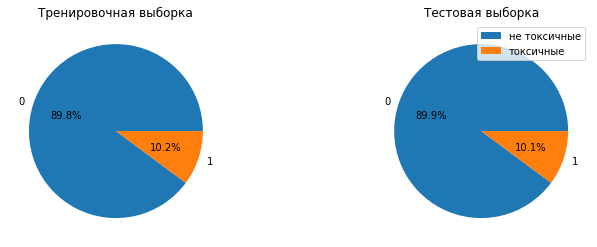

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].pie(y_train.value_counts(), autopct='%1.1f%%', labels=['0', '1'])
axes[1].pie(y_test.value_counts(), autopct='%1.1f%%', labels=['0', '1'])
axes[0].title.set_text('Тренировочная выборка')
axes[1].title.set_text('Тестовая выборка')
plt.legend(['не токсичные', 'токсичные'], loc="best");

Мы загрузили комментарии (англоязычные) и целевой признак в датасет, проверили на пропуски и дубликаты (их нет), почистили текст от лишних символов и лемматизировали, подготовили мешок слов, подготовили тренировочную и тестовую выборки для обучения моделей.

## Обучение

Обучим в пайплайне модели для задачи классификации:
- логистическую регрессию и
- дерево решений

и выберем лучшую метрику F1 на кросс-валидации.

In [ ]:
%%time
pipe_final = Pipeline([
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10,20),
        #'models__min_samples_split': range(2,20),
        #'models__min_samples_leaf': range(1,10),
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=50)], #solver='liblinear')],
        'models__C': [1,15,20,30,40],
        #'models__penalty': ['l1', 'l2'],
    },
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика F1 для лучшей модели на на кросс-валидации:', round(grid.best_score_, 4))

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LogisticRegression(C=40, max_iter=50, random_state=42))])
Метрика F1 для лучшей модели на на кросс-валидации: 0.7694
CPU times: user 20min 46s, sys: 4min 21s, total: 25min 7s
Wall time: 25min 9s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
%%time
y_pred = grid.best_estimator_.predict(X_test)
print('F1 лучшей модели на тестовой выборке', round(f1_score(y_test, y_pred), 4))

F1 лучшей модели на тестовой выборке 0.7848
CPU times: user 19 ms, sys: 18 ms, total: 37.1 ms
Wall time: 97 ms


In [ ]:
dummy_c = DummyClassifier().fit(X_train, y_train)
round(f1_score(y_test, dummy_c.predict(X_test)), 4)

0.0

Лучшая модель (из пайплайна) - логистическая регрессия с гиперпараметром C=40 и max_iter=50 даёт нужное качество метрики F1 = 0.7694 на кросс-валидации и 0.7848 на тесте (больше минимально требуемых 0.75).

Для проверки на адекватность использовали дамми (случайное угадывание), оно вообще даёт F1 = 0.

## Выводы

Логистическая регрессия (с гиперпараметрами C=40, max_iter=50) определяет токсичные комментарии на очищенном лемматизированном английском тексте с требуемой точностью (метрика на тесте F1 = 0.7848, что больше 0.75). Для оценки важности слов использовался TF-IDF.